# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



In [15]:
# Imports
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Data exploration 

## Plotting example images

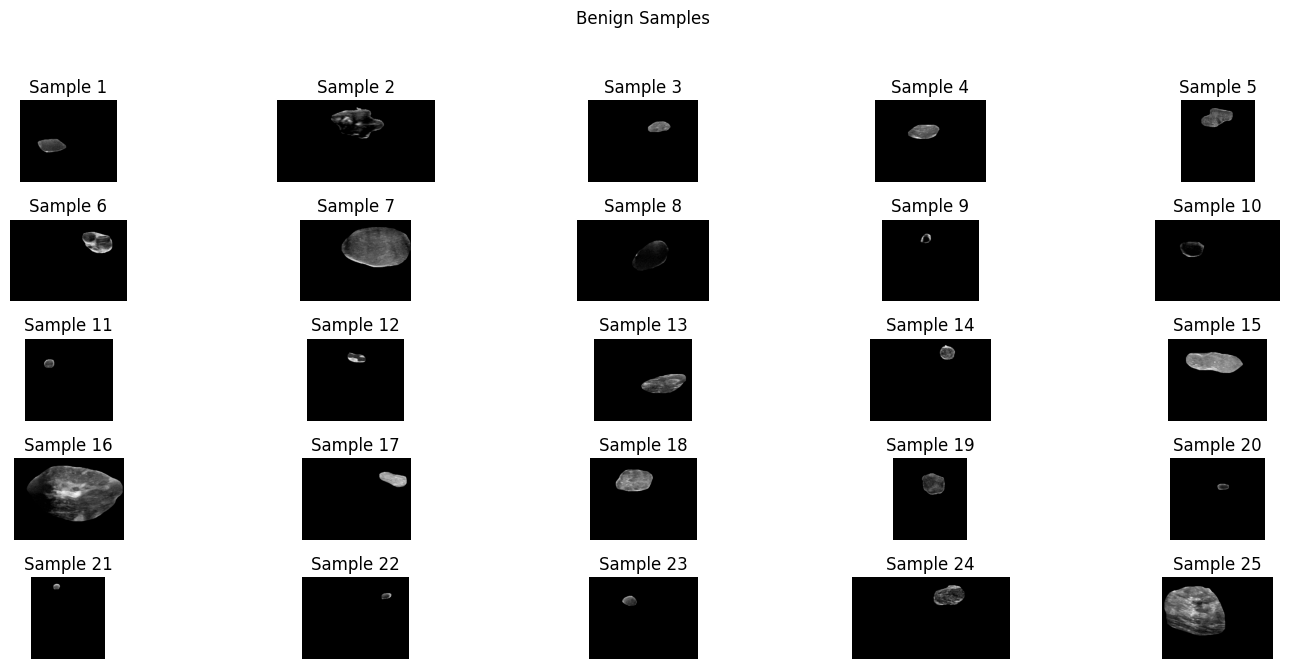

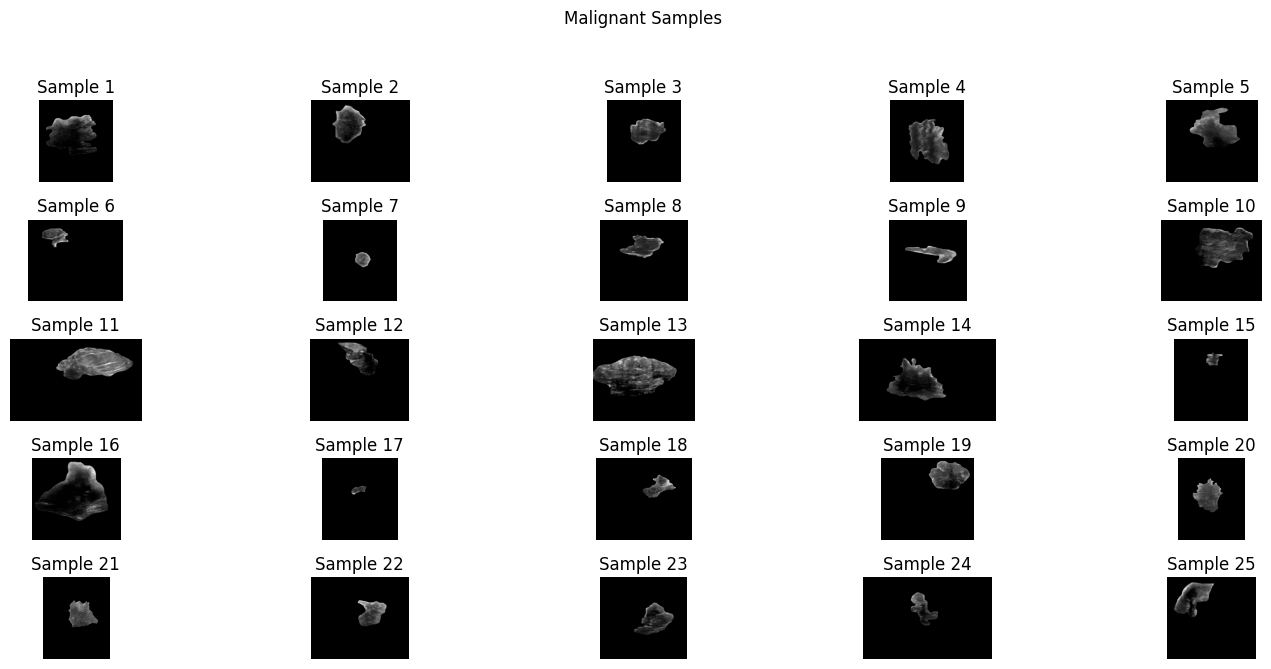

In [16]:
def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
plot_class_samples(training_path, 'benign', num_samples=25)

plot_class_samples(training_path, 'malignant', num_samples=25)

In [17]:
def create_classification_df(base_path):
    categories = ['benign', 'malignant'] 
    data = [] 

    for category in categories:
        class_folder = os.path.join(base_path, category)
        # List files in the directory
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]
        
        # Create a list of dictionaries containing the filename and classification
        data.extend([{'filename': f, 'classification': category} for f in image_files])
   
    df = pd.DataFrame(data)
    return df

training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
test_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Test_data'
train_df = create_classification_df(training_path)
test_df = create_classification_df(test_path)

df = pd.concat([train_df, test_df])
print(train_df.shape)
print(test_df.shape)
print(df.head())

(668, 2)
(100, 2)
           filename classification
0    benign (2).png         benign
1       case037.png         benign
2  benign (390).png         benign
3  benign (357).png         benign
4       case231.png         benign


## Is there a class imbalance? 

In [18]:
print(train_df['classification'].value_counts())
print(test_df['classification'].value_counts())

classification
benign       442
malignant    226
Name: count, dtype: int64
classification
benign       50
malignant    50
Name: count, dtype: int64


# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [21]:
training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
test_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Test_data'


# parameters
batch_size = 32
img_height = 224  
img_width = 224   

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',
    class_names=['benign', 'malignant'],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    label_mode='binary',
    image_size=(224, 224), 
    color_mode='grayscale', 
    batch_size=32)  

Found 668 files belonging to 2 classes.
Using 535 files for training.
Found 668 files belonging to 2 classes.
Using 133 files for validation.
Found 100 files belonging to 2 classes.


## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Baseline model


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers


model = Sequential()


model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same",input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10


2024-05-09 15:06:50.249999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.08371, expected 0.622453
2024-05-09 15:06:50.250053: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.03666, expected 1.5754
2024-05-09 15:06:50.250063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.08074, expected 1.61949
2024-05-09 15:06:50.250071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.6191, expected 1.15784
2024-05-09 15:06:50.250079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.70133, expected 1.24007
2024-05-09 15:06:50.250087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.8675, expected 1.40624
2024-05-09 15:06:50.250095: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.81686, expected 1.3556
2024-05-09 15:06:50.250103: E external/local_xla/xla/servi

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5530 - loss: 4.6850

2024-05-09 15:06:56.481051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.33115, expected 0.467215
2024-05-09 15:06:56.481108: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.3149, expected 1.45096
2024-05-09 15:06:56.481118: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.89817, expected 2.03423
2024-05-09 15:06:56.481126: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.57407, expected 1.71013
2024-05-09 15:06:56.481134: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.29753, expected 1.43359
2024-05-09 15:06:56.481141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.27941, expected 1.41547
2024-05-09 15:06:56.481149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.56697, expected 1.70303
2024-05-09 15:06:56.481157: E external/local_xla/xla/se

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5549 - loss: 4.8081

2024-05-09 15:07:01.362926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.67034, expected 0.783926
2024-05-09 15:07:01.362981: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.21481, expected 1.3284
2024-05-09 15:07:01.362992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.56631, expected 1.6799
2024-05-09 15:07:01.363002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.34798, expected 1.46157
2024-05-09 15:07:01.363011: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.92427, expected 1.03786
2024-05-09 15:07:01.363021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.3544, expected 1.46799
2024-05-09 15:07:01.363030: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.69556, expected 1.80915
2024-05-09 15:07:01.363039: E external/local_xla/xla/serv

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - accuracy: 0.5552 - loss: 5.0181 - val_accuracy: 0.6466 - val_loss: 3.6603
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6870 - loss: 4.3223 - val_accuracy: 0.6316 - val_loss: 50.9290
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7629 - loss: 3.5139 - val_accuracy: 0.5564 - val_loss: 6.2355
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6689 - loss: 3.5716 - val_accuracy: 0.6391 - val_loss: 15.4714
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7076 - loss: 1.4129 - val_accuracy: 0.6541 - val_loss: 4.4992
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6481 - loss: 2.9076 - val_accuracy: 0.6391 - val_loss: 2.9722
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6323 - loss: 4.3190 - val_accuracy: 0.6692 - val_loss: 2.4335
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7176 - loss: 0.9518 - val_accuracy: 0.6692 - val_loss

In [23]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [24]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()


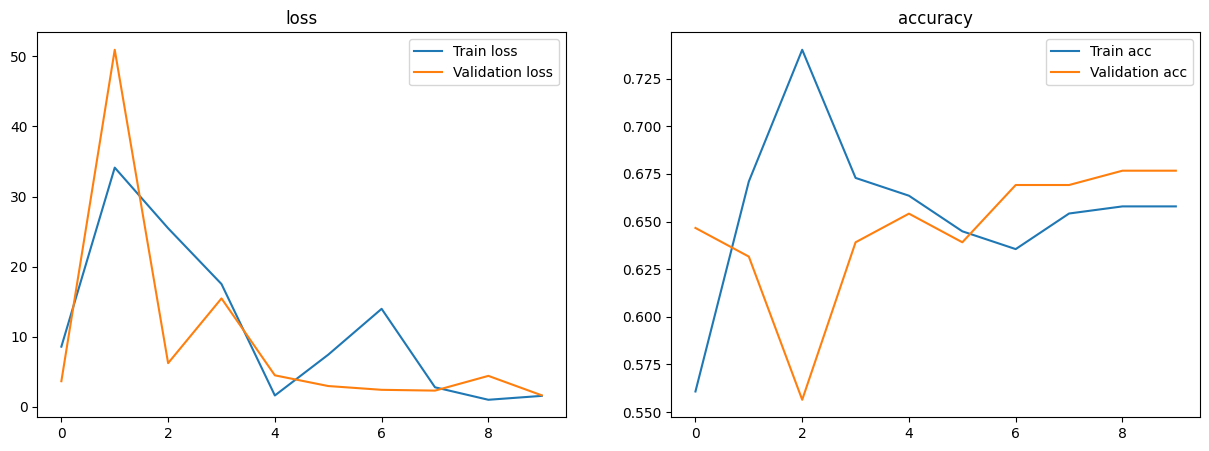

In [25]:
plot_history(history)

## Data Augmentation

### Building the model

In [26]:
model_2 = Sequential()


# Data Augmentation Layers

model_2.add(layers.RandomFlip("horizontal"))
model_2.add(layers.RandomZoom(0.1))
model_2.add(layers.RandomTranslation(0.2, 0.2))
model_2.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_2.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(64, activation="relu"))


model_2.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model_2.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model_2.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.5019 - loss: 1.8185 - val_accuracy: 0.7143 - val_loss: 0.6541
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6639 - loss: 0.6516 - val_accuracy: 0.6992 - val_loss: 0.6228
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6653 - loss: 0.5903 - val_accuracy: 0.6992 - val_loss: 0.6046
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6865 - loss: 0.6215 - val_accuracy: 0.6992 - val_loss: 0.5669
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6873 - loss: 0.5792 - val_accuracy: 0.7143 - val_loss: 0.5644
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6660 - loss: 0.5566 - val_accuracy: 0.6917 - val_loss: 0.5715
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7083 - loss: 0.5378 - val_accuracy: 0.7594 - val_loss: 0.5205
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7329 - loss: 0.5355 - val_accuracy: 0.7820 - 

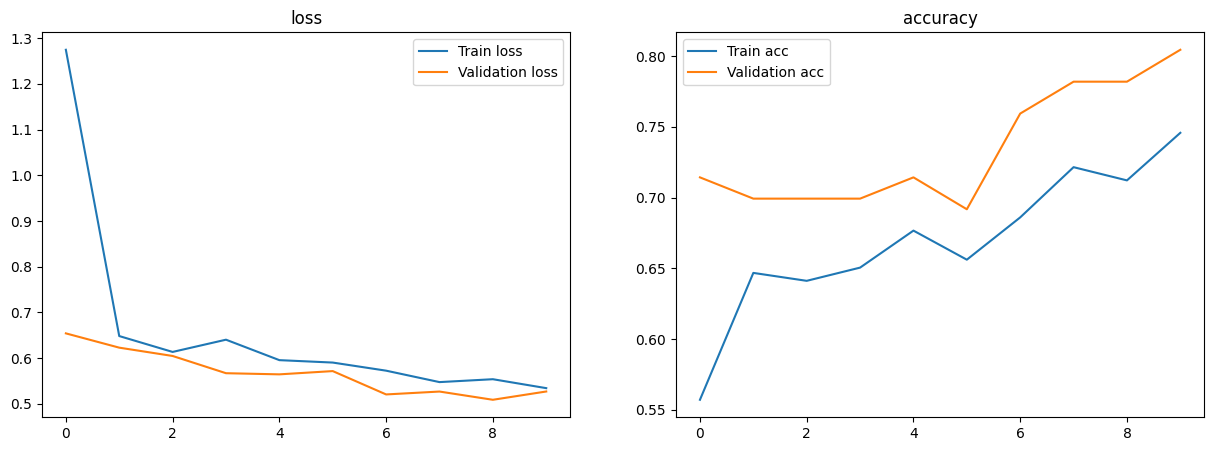

In [27]:
plot_history(history2)

In [32]:

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping



model_3 = Sequential()


# Data Augmentation Layers

model_3.add(layers.RandomFlip("horizontal"))
model_3.add(layers.RandomZoom(0.1))
model_3.add(layers.RandomTranslation(0.2, 0.2))
model_3.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_3.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Flatten())

model_3.add(layers.Dense(64, activation="relu"))


model_3.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)




# Train the model
history3 = model_3.fit(dataset, validation_data=validation_dataset, epochs=1000,batch_size=32, callbacks=[model_checkpoint, lr_reducer, early_stopper])



# Evaluate the model
loss, accuracy = model_3.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5655 - loss: 2.4679 - val_accuracy: 0.6917 - val_loss: 0.6653 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6569 - loss: 0.6555 - val_accuracy: 0.6917 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6804 - loss: 0.6303 - val_accuracy: 0.7143 - val_loss: 0.5923 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6789 - loss: 0.5962 - val_accuracy: 0.7143 - val_loss: 0.5789 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7048 - loss: 0.5599 - val_accuracy: 0.7444 - val_loss: 0.6497 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6832 - loss: 0.5773 - val_accuracy: 0.6842 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6774 - loss: 0.

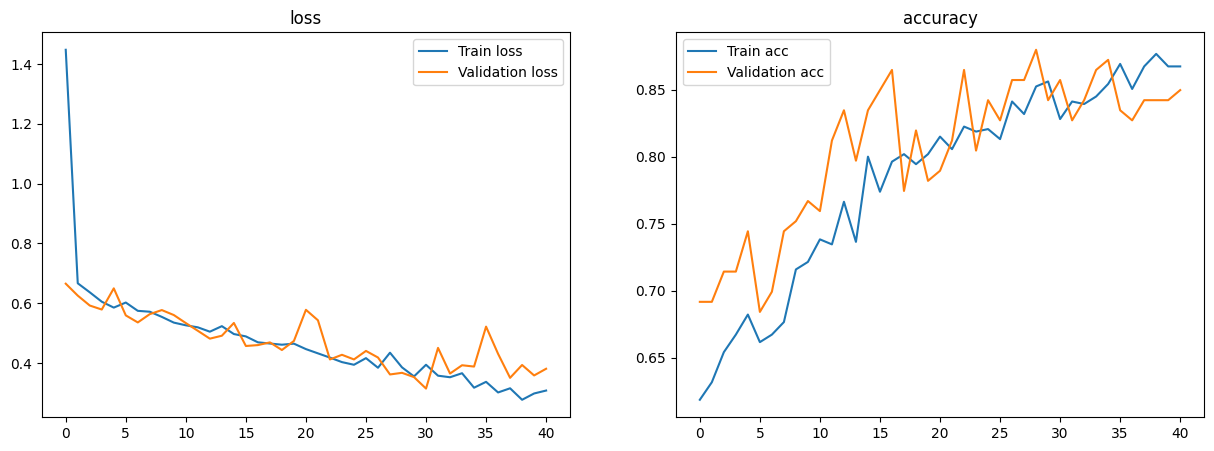

In [33]:
plot_history(history3)

In [34]:
# Evaluate the model on test_dataset
loss, accuracy = model_3.evaluate(test_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9008 - loss: 0.2989
Validation Loss: 0.3342404067516327
Validation Accuracy: 0.8899999856948853


## EfficientNetB2

In [35]:

# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
dataset_rgb = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)


# Load the test dataset
test_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    image_size=(224, 224),
    color_mode='rgb',
    batch_size=32)

Found 668 files belonging to 2 classes.
Using 535 files for training.
Found 668 files belonging to 2 classes.
Using 133 files for validation.
Found 100 files belonging to 2 classes.


In [39]:
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense


# Parameters for the dataset and model
batch_size = 64
num_classes = 2  # binary classification (benign vs malignant)


input_tensor=Input(shape=(img_height, img_width, 3))

x=layers.RandomFlip("horizontal")(input_tensor)
x=layers.RandomZoom([0.1, 0.3] )(x)
x=layers.RandomTranslation(0.3, 0.3)(x)
x=layers.RandomRotation([-1,1])(x)



#x=layers.RandomFlip("horizontal")(input_tensor)
#x=layers.RandomZoom(0.1)(x)
#x=layers.RandomTranslation(0.2, 0.2)(x)
#x=layers.RandomRotation(0.1)(x)



# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_tensor=input_tensor)(x)

# Freeze the pre-trained layers
base_model.trainable = False


# Add custom classification head
x = GlobalAveragePooling2D()(base_model)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='sigmoid')(x)



# Create the model
model_eff = Model(inputs=input_tensor, outputs=output)

# Compile the model
model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Display the model summary
model_eff.summary()

# Assuming you have defined your training and validation datasets
# Replace `train_dataset` and `val_dataset` with your actual datasets



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)





# Train the model

history_eff_improved= model_eff.fit(dataset_rgb,
                    validation_data=validation_dataset_rgb,
                    epochs=50,  batch_size=batch_size, callbacks=[model_checkpoint, lr_reducer, early_stopper]
                          )

# Evaluate the model
loss, accuracy = model_eff.evaluate(validation_dataset_rgb)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_6 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_6            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_6               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,949,984 (34.14 MB)

 Trainable params: 8,867,696 (33.83 MB)

 Non-trainable params: 82,288 (321.44 KB)

Epoch 1/50


2024-05-09 15:17:31.395659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_27_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 712ms/step - accuracy: 0.6320 - loss: 0.6161 - val_accuracy: 0.8496 - val_loss: 0.4256 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.8330 - loss: 0.4116 - val_accuracy: 0.8872 - val_loss: 0.3345 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8829 - loss: 0.3073 - val_accuracy: 0.8647 - val_loss: 0.3377 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.8826 - loss: 0.3115 - val_accuracy: 0.8947 - val_loss: 0.2901 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.9082 - loss: 0.2474 - val_accuracy: 0.8872 - val_loss: 0.3339 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.9001 - loss: 0.2447 - val_accuracy: 0.8722 - val_loss: 0.2913 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.8989 - l

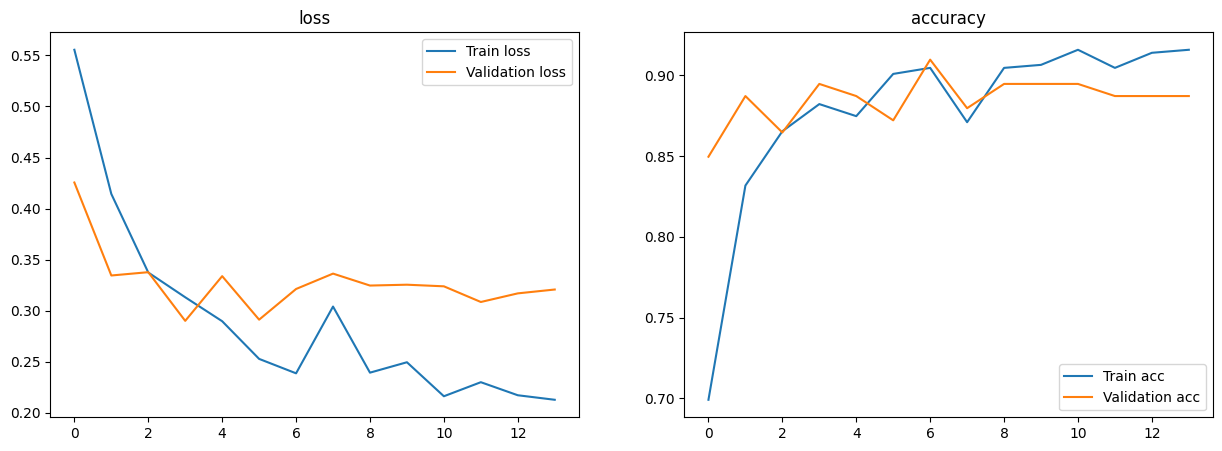

In [40]:
plot_history(history_eff_improved)

In [46]:

# Evaluate the model on test_dataset
loss, accuracy = model_eff.evaluate(test_dataset_rgb)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.2104
Test Loss: 0.21225787699222565
Test Accuracy: 0.9399999976158142


In [47]:
model_eff.predict(test_dataset_rgb)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[0.2527312 , 0.8701692 ],
       [0.28453183, 0.673651  ],
       [0.8127039 , 0.14991672],
       [0.26739094, 0.80578125],
       [0.30594173, 0.68427694],
       [0.9295021 , 0.053222  ],
       [0.501413  , 0.49904457],
       [0.6708187 , 0.27632162],
       [0.8910611 , 0.12262575],
       [0.38320243, 0.728944  ],
       [0.2458705 , 0.85934156],
       [0.30008262, 0.6808274 ],
       [0.19391316, 0.80891144],
       [0.8945017 , 0.07703432],
       [0.3739857 , 0.59975344],
       [0.8327247 , 0.22962439],
       [0.7692862 , 0.245373  ],
       [0.5174065 , 0.65841717],
       [0.4596676 , 0.5161037 ],
       [0.75106335, 0.19942679],
       [0.3751164 , 0.5429867 ],
       [0.3524951 , 0.5750636 ],
       [0.33411485, 0.7712849 ],
       [0.8969896 , 0.11110438],
       [0.9282688 , 0.07302901],
       [0.92854774, 0.02388853],
       [0.8745602 , 0.07937582],
       [0.3842837 , 0.6358326 ],
       [0.340082  , 0.61507356],
       [0.69718814, 0.2990212 ],
       [0.